# Import Required Libraries

In [ ]:
# Before importing please this please install required library into your virtual env [numpy pandas seaborn matplotlib wordcloud nltk scikit-learn imbalanced-learn mlxtend scikit-plot xgboost lightgbm catboost]

In [ ]:
import numpy as np
import pandas as pd
import datetime
import time
import urllib
import os
import re
import pickle
import nltk
import string
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier 
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import  LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from mlxtend.plotting import plot_confusion_matrix
from scikitplot.metrics import plot_roc_curve

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load Data

In [ ]:
def loadFile(name):
    directory = str(os.getcwd())
    filepath = os.path.join(directory, name)
    with open(filepath, "r",encoding='utf-8') as f:
        data = f.readlines()
    data = list(set(data))
    result = []
    for d in data:
        d = str(urllib.parse.unquote(d))
        result.append(d)
    return result

In [ ]:
badQueries = loadFile(r"C:\Users\singh\Downloads\bad\badqueries.txt") 
goodQueries = loadFile(r"C:\Users\singh\Downloads\good\goodqueries.txt")

# Replace your path here

In [ ]:
bad = pd.DataFrame(badQueries)
good = pd.DataFrame(goodQueries)

In [ ]:
bad_df = bad.copy()
good_df = good.copy()

In [ ]:
bad_df.columns = ["query"]
good_df.columns = ["query"]

In [ ]:
bad_df.head()

,query
0,echo QZBSFJ$((43+35))$(echo QZBSFJ)QZBSFJ//\n
1,"ABC<div style=""x:\x0Dexpression(javascript:ale..."
2,/scripts/phprint.php?module=vtiger_lang_crm_lf...
3,/inc/irayofuncs.php?irayodirhack=XXpathXX?\n
4,/scripts/modules.php?name=my_egallery\n


In [ ]:
good_df.head()

,query
0,/j river media center v11/\n
1,/customcontacttable/\n
2,/en-us/static/@95063/img/skins/default/overlay...
3,/rightnav_contact/\n
4,/191540/\n


In [ ]:
good_df["label"] = 0
bad_df["label"] = 1

In [ ]:
df = pd.concat([good_df, bad_df], axis=0)

In [ ]:
df.shape

(1310707, 2)

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.head()

,query,label
0,/javascript/smiles.part\n,0
1,/directory_jewelry/\n,0
2,/burrows_alternative/\n,0
3,/hdr-welcome/\n,0
4,/m53781/\n,0


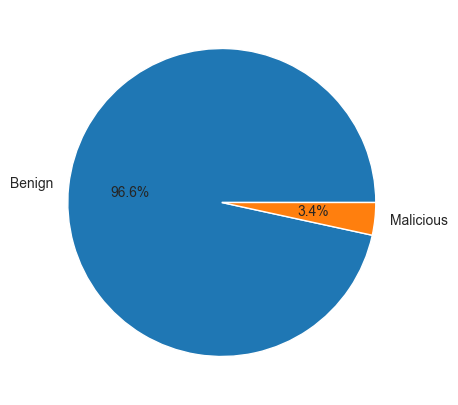

In [ ]:
total_0, total_1 = len(df[df["label"] == 0]), len(df[df["label"] == 1])
label = np.array(["Benign", "Malicious"])
values = np.array([total_0, total_1])
plt.figure(figsize=(5, 5))
plt.pie(values, labels=label, autopct="%.1f%%")
plt.show()

# Preprocess

In [ ]:
def clean_newline(column):
    column[:-2]
    return column[:-2]

In [ ]:
df["query"] = df["query"].apply(clean_newline)

In [ ]:
df.head()

,query,label
0,/javascript/smiles.par,0
1,/directory_jewelry,0
2,/burrows_alternative,0
3,/hdr-welcome,0
4,/m53781,0


In [ ]:
def clear_first_char(column):
    if column.startswith("/"):
        return column[1:]
    else:
        return column

In [ ]:
df["query"] = df["query"].apply(clear_first_char)

In [ ]:
df.head()

,query,label
0,javascript/smiles.par,0
1,directory_jewelry,0
2,burrows_alternative,0
3,hdr-welcome,0
4,m53781,0


In [ ]:
def xss_check(input_string):
    input_string = urllib.parse.unquote(input_string)
    xss_pattern=re.compile(r'(<|>|&lt;|&gt;|script|alert|document\.|onload\=|onerror\=|eval\(|expression\(|prompt\(|confirm\()')
    if xss_pattern.search(input_string.split("/")[-1]):
        return 1
    else:
        return 0

In [ ]:
df["is_xss"] = df["query"].apply(xss_check)

In [ ]:
df[df["is_xss"] == 1].head()

,query,label,is_xss
168,igtf0zon.do?<script>cross_site_scripting.nasl<...,1,1
241,zroo33l4.html?<meta http-equiv=set-cookie cont...,1,1
348,transcript_day1,1,1
526,"o6ebbirj.dll?<img src=""javascript:alert(cross_...",1,1
543,"<script>document.cookie=""testwtbo=4831;""</script",1,1


In [ ]:
def lfi_check(input_string):
    input_string = urllib.parse.unquote(input_string)
    lfi_pattern = re.compile(r'(file\:\/\/|(\.\.\/)|(\.\.\\))')
    if "=" in input_string.split("/")[-1]:
        if lfi_pattern.search(input_string.split("/")[-1].split("=", 1)[1]):
            return 1
        else:
            return 0
    elif lfi_pattern.search(input_string.split("/")[-1]):
        return 1
    else:
        return 0

In [ ]:
df["is_lfi"] = df["query"].apply(lfi_check)

In [ ]:
df[df["is_lfi"] == 1].sample(5)

,query,label,is_xss,is_lfi
267239,....\....\....\....\{FILE,1,0,1
566910,.\\..\\.\\..\\.\\..\\.\\..\\{FILE,1,0,1
162414,..\..\..\..\..\..\{FILE,1,0,1
1073715,..%5c..%5c..%5c..%5c..%5c..%5c{FILE,1,0,1
225395,cgi-bin/search.cgi?..\..\..\..\..\..\winnt\win.in,1,0,1


In [ ]:
def command_injection_check(input_string):
    input_string = urllib.parse.unquote(input_string)
    cmd_injection_pattern = re.compile(r'(;|\||`|\$\(|\$\{)')

    if cmd_injection_pattern.search(input_string):
        return 1
    else:
        return 0

In [ ]:
df["is_oci"] = df["query"].apply(command_injection_check)

In [ ]:
df[df["is_oci"] == 1].sample(5)

,query,label,is_xss,is_lfi,is_oci
837667,%27; str=$(echo DJSHTX); str1=${#str}; if [ 7 ...,1,0,0,1
1106485,"""`'><script>\x09javascript:alert(1)</script",1,1,0,1
1225241,scripts/index.php?search='><script>alert('auto...,1,1,0,1
603326,"<img src=""javascript:alert(cross_site_scriptin...",1,1,0,1
141284,"fpnpp5zg.cfc?<script>document.cookie=""testyias...",1,1,0,1


In [ ]:
def sql_injection_check(input_string):
    input_string = urllib.parse.unquote(input_string)
    sqli_pattern = re.compile(r'(\b(SELECT|INSERT|UPDATE|DELETE|FROM|WHERE|AND|OR|UNION|ALL|EXEC|EXECUTE|DECLARE|CAST)\b)')

    if sqli_pattern.search(input_string):
        return 1
    else:
        return 0

In [ ]:
df["is_sqli"] = df["query"].apply(sql_injection_check)

In [ ]:
df[df["is_sqli"] == 1].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli
303213,' OR '1'='1' -,1,0,0,0,1
1267532,"' SELECT IF(1=1,'true','false'",1,0,0,0,1
5111,"523'/*!LIMIT*/1,1/*!UNION*//*!ALL*//*!SELECT*/...",1,0,0,0,1
404836,"23�' LIMIT 1,1 UNION ALL SELECT CONCAT(0x3a6d7...",1,0,0,0,1
1191229,WHERE 1=1 AND 1=1-,1,0,0,0,1


In [ ]:
def semicolon_count(url):
    url = urllib.parse.unquote(url)
    return url.count(";")

In [ ]:
df["semicolon_count"] = df["query"].apply(semicolon_count)

In [ ]:
df[df["semicolon_count"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count
169063,main.php?stuff=;sleep\x099\x09,1,0,0,1,0,1
155940,"""; str=$(echo GRQQCI); str1=${#str}; if [ 4 -n...",1,0,0,1,0,6
823628,help.php?q=';rm\x09q61196872\x09,1,0,0,1,0,1
526697,"examples/jsp/error/server.pt?open=space&name=""...",1,1,0,1,0,1
784870,help.php?q=;uname\x09>q81281166\x09,1,1,0,1,0,1


In [ ]:
def underscore_count(url):
    url = urllib.parse.unquote(url)
    return url.count("_")

In [ ]:
df["underscore_count"] = df["query"].apply(underscore_count)

In [ ]:
df[df["underscore_count"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count
1167257,members_ic,0,0,0,0,0,0,1
953596,rx_fvi3v6li,0,0,0,0,0,0,1
228412,emperor_claudius,0,0,0,0,0,0,1
102181,interface/login_screen.php?error=1&site,0,0,0,0,0,0,1
676449,"examples/servlets/servlet/login.php?course=""><...",1,1,0,0,0,0,1


In [ ]:
def questionmark_count(url):
    url = urllib.parse.unquote(url)
    return url.count("?")

In [ ]:
df["questionmark_count"] = df["query"].apply(questionmark_count)

In [ ]:
df[df["questionmark_count"] > 0].sample(5) 

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count
852275,arash_lib/class/arash_gadmin.class.php?arashli...,0,0,0,0,0,0,3,1
963282,include/engine/content/elements/menu.php?confi...,0,0,0,0,0,0,0,1
769770,cacti/new_images.php?order=linpha_order_sql_in...,0,0,0,0,0,0,5,1
1254943,hioxbannerrotate.php?hm=http://192.168.202.118...,0,0,0,0,0,0,0,1
901756,web/betablockmodules/editprofilemodule/dynamic...,0,0,0,0,0,0,1,1


In [ ]:
def equal_count(url):
    url = urllib.parse.unquote(url)
    return url.count("=")

In [ ]:
df["equal_count"] = df["query"].apply(equal_count)

In [ ]:
df[df["equal_count"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count
868862,examples/jsp/cal/rpc.php?cmd=display_get_reque...,0,0,0,0,0,0,2,1,2
567773,examples/jsp/cal/search/show.pl?url=file:/etc/...,1,0,0,0,0,0,0,1,1
225093,administrator/components/com_jim/install.jim.p...,0,0,0,0,0,0,3,2,1
560598,main.php?logout=del\x0bq69125734&rem\x0,0,0,0,0,0,0,0,1,1
938129,script/ident/ident.inc.php?path_inc=http://192...,1,0,0,0,0,0,1,1,1


In [ ]:
def and_count(url):
    url = urllib.parse.unquote(url)
    return url.count("&")

In [ ]:
df["and_count"] = df["query"].apply(equal_count)

In [ ]:
df[df["and_count"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count
341165,<SCRIPT SRC=//ha.ckers.org/.j,1,0,0,0,0,0,0,0,1,1
932092,examples/jsp/jsp2/jspx/lib/dbman_filter.inc.ph...,1,0,0,0,0,0,2,1,1,1
1047015,cfagcms/themes/default/index.php?main=http://1...,0,0,0,0,0,0,0,1,1,1
2342,main/inc/stylesheet.php?version=133192104,0,0,0,0,0,0,0,1,1,1
746263,administrator/components/com_jcs/view/register...,0,0,0,0,0,0,3,1,1,1


In [ ]:
def or_count(url):
    url = urllib.parse.unquote(url)
    return url.count("|")

In [ ]:
df["or_count"] = df["query"].apply(or_count)

In [ ]:
df[df["or_count"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count
571583,"""| [ 1 -ne $(echo YPWXZB | tr -d '\n' | wc -c)...",1,0,0,1,0,0,0,0,0,0,5
223274,phpmyadmin/wps_shop.cgi?action=showartikel&cat...,0,0,0,1,0,0,1,1,4,4,1
825301,'| [ 8 -ne $(echo XOCDUH | tr -d '\n' | wc -c)...,1,0,0,1,0,0,0,0,0,0,5
854773,main.php?logout=|ping\xa0-w\xa011000\xa0-n\xa0...,0,0,0,1,0,0,0,1,1,1,2
1208035,awstats/awstats.pl?migrate=|echo;/bin/echo -en...,1,0,0,1,0,2,0,1,1,1,2


In [ ]:
def dotcount(url):
    url = urllib.parse.unquote(url)
    return url.count(".")

In [ ]:
df["dot_count"] = df["query"].apply(dotcount)

In [ ]:
df[df["dot_count"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count
514412,javascript/children.asm,0,0,0,0,0,0,0,0,0,0,0,1
1047288,phpmyadmin/admin/setup.ph,0,0,0,0,0,0,0,0,0,0,0,1
920158,javascript/stock.p,0,0,0,0,0,0,0,0,0,0,0,1
1278774,controllers/videocontroller.php?basedir=http:/...,0,0,0,0,0,0,0,1,1,1,0,3
8019,javascript/xsql.asm,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
def atcount(url):
    url = urllib.parse.unquote(url)
    return url.count("@")

In [ ]:
df["at_count"] = df["query"].apply(atcount)

In [ ]:
df[df["at_count"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count
824955,callboth.php?seq=654321&out=123456&in=13319190...,0,0,0,0,0,0,3,1,3,3,0,2,1
513388,dp_logs.php?homedir=@rfiur,0,0,0,0,0,0,1,1,1,1,0,1,1
70315,<STYLE>@import'http://ha.ckers.org/xss.css';</...,1,0,0,1,0,1,0,0,0,0,0,3,1
251616,main.php?stuff=@,1,0,0,0,0,0,0,1,1,1,0,1,1
79051,include/pear/it_error.php?basepath=@rfiurl?bas...,0,0,0,0,0,0,1,2,2,2,0,1,2


In [ ]:
def subdircount(url):
    url = urllib.parse.unquote(url)
    parsed_url = urllib.parse.urlparse(url)
    subdirectory_path = len(parsed_url.path.strip("/").split("/"))
    return subdirectory_path

In [ ]:
df["subdir_count"] = df["query"].apply(subdircount)

In [ ]:
df[df["subdir_count"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count
363570,200210303623443743080310,0,0,0,0,0,0,0,0,0,0,0,0,0,1
306409,define-redbud,0,0,0,0,0,0,0,0,0,0,0,0,0,1
685947,hotspotstatusmap,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1227958,hawksnest,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1177416,button40,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
def query_len(url):
    parsed_url = urllib.parse.urlparse(url)
    if len(parsed_url.query) > 0:
        query_params = urllib.parse.parse_qs(parsed_url.query)
        query_string = "".join(f"{value[0]}" for key, value in query_params.items())    
        return len(query_string)
    else:
        return 0

In [ ]:
df["query_len"] = df["query"].apply(query_len)

In [ ]:
df[df["query_len"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len
1047892,content/content.php?fileloc=http://192.168.202...,0,0,0,0,0,0,0,2,1,1,0,4,0,2,40
176020,"gvx7m5ti.jsp?<script>document.cookie=""testwldz...",1,1,0,1,0,1,0,1,2,2,0,2,0,1,24
281467,arash_lib/include/list_features.inc.php?arashl...,0,0,0,0,0,0,3,1,1,1,0,5,0,3,36
29367,webroot/css.php?configs=http://192.168.202.118...,0,0,0,0,0,0,0,1,1,1,0,4,0,2,42
921417,betablockmodules/externalfeedmodule/externalfe...,0,0,0,0,0,0,1,1,1,1,0,4,0,3,40


In [ ]:
def param_count(url):
    parsed_url = urllib.parse.urlparse(url)
    query_params = urllib.parse.parse_qs(parsed_url.query)
    return len(query_params)

In [ ]:
df["param_count"] = df["query"].apply(param_count)

In [ ]:
df[df["param_count"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count
1137950,"oie504mr.cgi?<script>document.cookie=""testtpby...",1,1,0,1,0,1,0,1,2,2,0,2,0,1,24,1
687750,admin/plugins/online_users/main.php?globals[pt...,0,0,0,0,0,0,2,1,1,1,0,4,0,4,42,1
445888,help.php?q='\x0auname\x09>q87897781\x09,1,1,0,0,0,0,0,1,1,1,0,1,0,1,28,1
832839,download_engine_v1.4.3/admin/enginelib/class.p...,0,0,0,0,0,0,3,1,1,1,0,7,0,4,40,1
520248,spip-v1-7-2/inc-calcul.php3?squelette_cache=ht...,0,0,0,0,0,0,1,2,1,1,0,4,0,2,41,1


In [ ]:
def total_digits_in_url(url):
    total_digits = 0
    for text in list(map(str, "0123456789")):
        total_digits += url.lower().count(text)
        
    return total_digits

In [ ]:
df["total_digits_url"] = df["query"].apply(total_digits_in_url)

In [ ]:
df[df["total_digits_url"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url
589078,1912269243,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,10
297358,000032252,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,9
535561,dc12slogan,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2
90646,ygkjkngd.do?<meta http-equiv=set-cookie conten...,1,1,0,0,0,0,0,1,3,3,0,1,0,1,34,1,4
123994,2213-wbginfrastructure_buyingadvice,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,4


In [ ]:
def total_letter_in_url(url):
    total_letter = 0
    for text in url:
        if text not in "0123456789":
            if text not in string.punctuation:
                total_letter += 1
        
    return total_letter

In [ ]:
df["total_letter_url"] = df["query"].apply(total_letter_in_url)

In [ ]:
df[df["total_letter_url"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url
144337,ad041805,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,6,2
1029518,javascript/commerce.cf,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,20
1110463,usenext-download,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,15
736111,javascript/survey.ra,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,18
969901,bandolino-pink,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,13


In [ ]:
tokenizer = RegexpTokenizer(r"[A-Za-z]+")

In [ ]:
df["url_tokenized"] = df["query"].apply(lambda x: tokenizer.tokenize(x))

In [ ]:
df[df["url_tokenized"] != "[]"].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized
791075,wareout,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,7,[wareout]
1163031,046306,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,6,0,[]
642042,106841,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,6,0,[]
1150525,javascript/rep.er,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,15,"[javascript, rep, er]"
107563,045369,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,6,0,[]


In [ ]:
stemmer = SnowballStemmer("english")

In [ ]:
def stem_url(column):
    words = [stemmer.stem(word) for word in column if len(word) >= 3]
    return " ".join(words)

In [ ]:
df["url_stemmed"] = df["url_tokenized"].apply(stem_url)

In [ ]:
df[df["url_stemmed"] != "[]"].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed
1208686,browse-493848,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,6,6,[browse],brows
641596,1127-143857,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,10,0,[],
1108286,q8347478,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,7,1,[q],
613768,buycheapphenter,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,15,[buycheapphenter],buycheapphent
505813,1131564353,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,10,0,[],


In [ ]:
def total_digits_domain(url):
    parsed_url = urllib.parse.urlparse(url)
    clean_url = url.replace(parsed_url.query, "")
    path_components = [component for component in clean_url.split('/') if component]
    if path_components:
        until_last_directory = "".join([word for word in path_components[:-1]])
        return total_digits_in_url(until_last_directory)
    else:
        return 0

In [ ]:
df["total_digits_domain"] = df["query"].apply(total_digits_domain)

In [ ]:
df[df["total_digits_domain"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain
1117071,sid=xxxxxxxxxxxxxxxxxxxxxxxxxxxx&shopid=http:/...,0,0,0,0,0,0,0,0,2,2,0,3,0,4,0,0,16,55,"[sid, xxxxxxxxxxxxxxxxxxxxxxxxxxxx, shopid, ht...",sid xxxxxxxxxxxxxxxxxxxxxxxxxxxx shopid http m...,16
833940,"""`'><script>\xE1\xA0\x8Ejavascript:alert(1)</s...",1,1,0,1,0,0,0,0,0,0,0,0,0,2,0,0,4,33,"[script, xE, xA, x, Ejavascript, alert, script]",script ejavascript alert script,4
532346,towels-0.1/src/scripture.php?pageheaderfile=ht...,1,0,0,0,0,0,0,1,1,1,0,5,0,3,41,1,19,51,"[towels, src, scripture, php, pageheaderfile, ...",towel src scriptur php pageheaderfil http dckq...,2
217288,en-us/account/typo3/index.ph,0,0,0,0,0,0,0,0,0,0,0,1,0,4,0,0,1,22,"[en, us, account, typo, index, ph]",account typo index,1
975883,<svg><script>a<svg//onload=confirm(2) />lert(1...,1,1,0,0,0,0,0,0,1,1,0,0,0,5,0,0,2,37,"[svg, script, a, svg, onload, confirm, lert, s...",svg script svg onload confirm lert script,2


In [ ]:
def total_letter_domain(url):
    parsed_url = urllib.parse.urlparse(url)
    clean_url = url.replace(parsed_url.query, "")
    path_components = [component for component in clean_url.split('/') if component]
    if path_components:
        until_last_directory = "".join([word for word in path_components[:-1]])
        return total_letter_in_url(until_last_directory)
    else:
        return 0

In [ ]:
df["total_letter_domain"] = df["query"].apply(total_letter_domain)

In [ ]:
df[df["total_letter_domain"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain
146651,javascript/citrix.r,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,17,"[javascript, citrix, r]",javascript citrix,0,10
554302,javascript/pt.sq,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,14,"[javascript, pt, sq]",javascript,0,10
540061,javascript/travel.htm,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,19,"[javascript, travel, htm]",javascript travel htm,0,10
197791,bin/view_item?html_file=../../../../../../../....,1,0,0,0,0,0,2,1,1,1,0,20,0,2,43,1,1,29,"[bin, view, item, html, file, etc, passwd, x]",bin view item html file etc passwd,0,3
841722,javascript/gwt.pe,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,15,"[javascript, gwt, pe]",javascript gwt,0,10


In [ ]:
def total_digits_path(url):
    parsed_url = urllib.parse.urlparse(url)
    clean_url = url.replace(parsed_url.query, "")
    path_components = [component for component in clean_url.split('/') if component]
    if path_components:
        last_directory = "".join([word for word in path_components[-1]])
        return total_digits_in_url(last_directory)
    else:
        return total_digits_in_url(clean_url)

In [ ]:
df["total_digits_path"] = df["query"].apply(total_digits_path)

In [ ]:
df[df["total_digits_path"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path
732377,042755,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,6,0,[],,0,0,6
1228697,70-webspace,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,8,[webspace],webspac,0,0,2
246055,000022739,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,9,0,[],,0,0,9
713243,243014,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,6,0,[],,0,0,6
950061,008300,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,6,0,[],,0,0,6


In [ ]:
def total_letter_path(url):
    parsed_url = urllib.parse.urlparse(url)
    clean_url = url.replace(parsed_url.query, "")
    path_components = [component for component in clean_url.split('/') if component]
    if path_components:
        last_directory = "".join([word for word in path_components[-1]])
        return total_letter_in_url(last_directory)
    else:
        return total_letter_in_url(clean_url)

In [ ]:
df["total_letter_path"] = df["query"].apply(total_letter_path)

In [ ]:
df[df["total_letter_path"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path
618642,choice hotels,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,13,"[choice, hotels]",choic hotel,0,0,0,13
1177235,psichologija,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,12,[psichologija],psichologija,0,0,0,12
637790,"jujgxwav.do?<script>document.cookie=""testknim=...",1,1,0,1,0,1,0,1,2,2,0,2,0,1,24,1,4,44,"[jujgxwav, do, script, document, cookie, testk...",jujgxwav script document cooki testknim script,0,0,0,10
10163,selfpub,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,7,[selfpub],selfpub,0,0,0,7
819139,~giffin,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6,[giffin],giffin,0,0,0,6


In [ ]:
def has_extension(url):
    url = urllib.parse.unquote(url)
    parsed_url = urllib.parse.urlparse(url)
    query_params = urllib.parse.parse_qs(parsed_url.query)
    path = parsed_url.path
    file_extension = os.path.splitext(path)[1]
    if not query_params or not file_extension:
        return 0
    else:
        return 1

In [ ]:
df["has_extension"] = df["query"].apply(has_extension)

In [ ]:
df[df["has_extension"] == 1].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension
614893,scripts/index.php?op=viewalbum&albumid=-1/**/u...,1,0,0,0,0,0,0,1,3,3,0,1,0,2,68,2,25,50,"[scripts, index, php, op, viewalbum, albumid, ...",script index php viewalbum albumid union selec...,0,7,0,8,1
408350,forum1_professionnel.asp?n=1771&amp;nn=`/etc/p...,1,0,0,1,0,2,1,1,3,3,0,1,0,1,17,2,5,43,"[forum, professionnel, asp, n, amp, nn, etc, p...",forum professionnel asp amp etc passwd amp page,0,0,1,21,1
946961,plugins/spamx/ipofurl.examine.class.php?_conf[...,0,0,0,0,0,0,1,1,1,1,0,6,0,3,41,1,17,58,"[plugins, spamx, ipofurl, examine, class, php,...",plugin spamx ipofurl examin class php conf pat...,0,12,0,22,1
942004,files/amazon-bestsellers.php?carppath=http://1...,0,0,0,0,0,0,0,1,1,1,0,4,0,2,41,1,17,49,"[files, amazon, bestsellers, php, carppath, ht...",file amazon bestsel php carppath http dckqcc a...,0,5,0,20,1
839095,scripts/al_initialize.php?alpath=/etc/passwd\x0,1,0,0,0,0,0,1,1,1,1,0,1,0,2,14,1,1,38,"[scripts, al, initialize, php, alpath, etc, pa...",script initi php alpath etc passwd,0,7,0,15,1


In [ ]:
def find_extension(url):
    url = urllib.parse.unquote(url)
    parsed_url = urllib.parse.urlparse(url)
    query_params = urllib.parse.parse_qs(parsed_url.query)
    path = parsed_url.path
    file_extension = os.path.splitext(path)[1]
    if not file_extension:
        return ""
    else:
        return file_extension

In [ ]:
df["extension"] = df["query"].apply(find_extension)

In [ ]:
df[df["extension"] != ""].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension
740006,javascript/phpeventcalendar.ym,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,28,"[javascript, phpeventcalendar, ym]",javascript phpeventcalendar,0,10,0,18,0,.ym
180892,javascript/feature.xsl,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,20,"[javascript, feature, xsl]",javascript featur xsl,0,10,0,10,0,.xsl
993605,javascript/configs.dum,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,20,"[javascript, configs, dum]",javascript config dum,0,10,0,10,0,.dum
804721,interface/login/login_title.ph,0,0,0,0,0,0,1,0,0,0,0,1,0,3,0,0,0,26,"[interface, login, login, title, ph]",interfac login login titl,0,14,0,12,0,.ph
289699,niet230847909.as,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,9,6,"[niet, as]",niet,0,0,9,6,0,.as


In [ ]:
def has_parameter(url):
    parsed_url = urllib.parse.urlparse(url)
    if len(parsed_url.query) > 0:
        return 1
    else:
        return 0

In [ ]:
df["has_parameter"] = df["query"].apply(has_parameter)

In [ ]:
df[df["has_parameter"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension,has_parameter
1025768,mapserv.exe?map=mapserver_detect.nasl.ma,1,0,0,0,0,0,1,1,1,1,0,3,0,1,24,1,0,34,"[mapserv, exe, map, mapserver, detect, nasl, ma]",mapserv exe map mapserv detect nasl,0,0,0,10,1,.exe,1
429715,"82q7ywa8.cfm?<script>document.cookie=""testpwew...",1,1,0,1,0,1,0,1,2,2,0,2,0,1,24,1,8,41,"[q, ywa, cfm, script, document, cookie, testpw...",ywa cfm script document cooki testpwew script,0,0,4,7,1,.cfm,1
580077,examples/jsp/error/admin/addentry.php?phpbb_ro...,1,0,0,0,0,0,2,1,1,1,0,1,0,5,14,1,1,55,"[examples, jsp, error, admin, addentry, php, p...",exampl jsp error admin addentri php phpbb root...,0,21,0,11,1,.php,1
580709,"main.php?logout=&ping,-w,10000,-n,1,1.2.3.4&rem",0,0,0,0,0,0,0,1,1,1,0,4,0,1,0,0,10,22,"[main, php, logout, ping, w, n, rem]",main php logout ping rem,0,0,0,7,0,.php,1
997438,phpmyadmin/documentation.html?whatever)=,0,0,0,0,0,0,0,1,1,1,0,1,0,2,0,0,0,35,"[phpmyadmin, documentation, html, whatever]",phpmyadmin document html whatev,0,10,0,17,0,.html,1


In [ ]:
def find_parameter_name(url):
    parsed_url = urllib.parse.urlparse(url)
    if len(parsed_url.query) > 0:
        query_params = urllib.parse.parse_qs(parsed_url.query)
        query_string = " ".join(f"{key}" for key, value in query_params.items())    
        return query_string
    else:
        return ""

In [ ]:
df["parameters"] = df["query"].apply(find_parameter_name)

In [ ]:
df[df["parameters"] != ""].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension,has_parameter,parameters
815752,wapchat/src/eng.createroom.php?sysfiledir=http...,0,0,0,0,0,0,0,1,1,1,0,5,0,3,42,1,16,54,"[wapchat, src, eng, createroom, php, sysfiledi...",wapchat src eng createroom php sysfiledir http...,0,10,0,16,1,.php,1,sysfiledir
594975,"y8pmygrp.dll?<img src=""javascript:alert(cross_...",1,1,0,1,0,1,2,1,1,1,0,2,0,1,46,1,1,54,"[y, pmygrp, dll, img, src, javascript, alert, ...",pmygrp dll img src javascript alert cross site...,0,0,1,10,1,.dll,1,<img src
772114,belegungsplan/wochenuebersicht.inc.php?root=ht...,0,0,0,0,0,0,0,1,1,1,0,5,0,2,33,1,16,48,"[belegungsplan, wochenuebersicht, inc, php, ro...",belegungsplan wochenuebersicht inc php root ht...,0,13,0,22,1,.php,1,root
783693,includes/blogger.php?path_prefix=XXpathX,1,0,0,0,0,0,1,1,1,1,0,1,0,2,7,1,0,35,"[includes, blogger, php, path, prefix, XXpathX]",includ blogger php path prefix xxpathx,0,8,0,10,1,.php,1,path_prefix
343485,classes/auth/openid/bigmath.php?_env[asicms][p...,0,0,0,0,0,0,1,1,1,1,0,4,0,4,42,1,16,58,"[classes, auth, openid, bigmath, php, env, asi...",class auth openid bigmath php env asicm path h...,0,17,0,10,1,.php,1,_env[asicms][path]


In [ ]:
df.columns

Index(['query', 'label', 'is_xss', 'is_lfi', 'is_oci', 'is_sqli',
       'semicolon_count', 'underscore_count', 'questionmark_count',
       'equal_count', 'and_count', 'or_count', 'dot_count', 'at_count',
       'subdir_count', 'query_len', 'param_count', 'total_digits_url',
       'total_letter_url', 'url_tokenized', 'url_stemmed',
       'total_digits_domain', 'total_letter_domain', 'total_digits_path',
       'total_letter_path', 'has_extension', 'extension', 'has_parameter',
       'parameters'],
      dtype='object')

In [ ]:
features = ['is_xss', 'is_lfi', 'is_oci', 'is_sqli',
       'semicolon_count', 'underscore_count', 'questionmark_count',
       'equal_count', 'and_count', 'or_count', 'dot_count', 'at_count',
       'subdir_count', 'query_len', 'param_count', 'total_digits_url',
       'total_letter_url', 'total_digits_domain', 'total_letter_domain', 
       'total_digits_path', 'total_letter_path', 'has_extension','has_parameter']

In [ ]:
df.head()

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension,has_parameter,parameters
0,javascript/smiles.par,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,19,"[javascript, smiles, par]",javascript smile par,0,10,0,9,0,.par,0,
1,directory_jewelry,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,16,"[directory, jewelry]",directori jewelri,0,0,0,16,0,,0,
2,burrows_alternative,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,18,"[burrows, alternative]",burrow altern,0,0,0,18,0,,0,
3,hdr-welcome,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,10,"[hdr, welcome]",hdr welcom,0,0,0,10,0,,0,
4,m53781,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5,1,[m],,0,0,5,1,0,,0,


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310707 entries, 0 to 1310706
Data columns (total 29 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   query                1310707 non-null  object
 1   label                1310707 non-null  int64 
 2   is_xss               1310707 non-null  int64 
 3   is_lfi               1310707 non-null  int64 
 4   is_oci               1310707 non-null  int64 
 5   is_sqli              1310707 non-null  int64 
 6   semicolon_count      1310707 non-null  int64 
 7   underscore_count     1310707 non-null  int64 
 8   questionmark_count   1310707 non-null  int64 
 9   equal_count          1310707 non-null  int64 
 10  and_count            1310707 non-null  int64 
 11  or_count             1310707 non-null  int64 
 12  dot_count            1310707 non-null  int64 
 13  at_count             1310707 non-null  int64 
 14  subdir_count         1310707 non-null  int64 
 15  query_len      

# Feature Scaling

In [ ]:
X = df.drop(["query", "label", "url_tokenized", "url_stemmed", "extension", "parameters"], axis=1)
y = df["label"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [ ]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train.ravel())

# Model

In [ ]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

In [ ]:
def cross_validation(model, X_train, y_train):
    model_log = pd.DataFrame(columns=["Train Time", "Test Time", "Accuracy", "F1", "Precision", "Recall"])
    for fold, (train_, test_) in enumerate(skf.split(X=X_train, y=y_train)):
        xtrain = X_train[train_, :]
        xtest = X_train[test_, :]
        ytrain = y_train[train_]
        ytest = y_train[test_]

        start = time.time()
        model.fit(xtrain, ytrain)
        end = time.time()
        train_time = end - start

        start = time.time()
        y_pred = model.predict(xtest)
        print(f"The fold is: {fold}")
        end = time.time()
        test_time = end - start

        cm = confusion_matrix(ytest, y_pred)

        model_log.loc[fold, "Train Time"] = train_time
        model_log.loc[fold, "Test Time"] = test_time
        model_log.loc[fold, "Accuracy"] = accuracy_score(ytest, y_pred)
        model_log.loc[fold, "F1"] = f1_score(ytest, y_pred)
        model_log.loc[fold, "Precision"] = precision_score(ytest, y_pred)
        model_log.loc[fold, "Recall"] = recall_score(ytest, y_pred)

    return model_log, cm

The fold is: 0
The fold is: 1
The fold is: 2


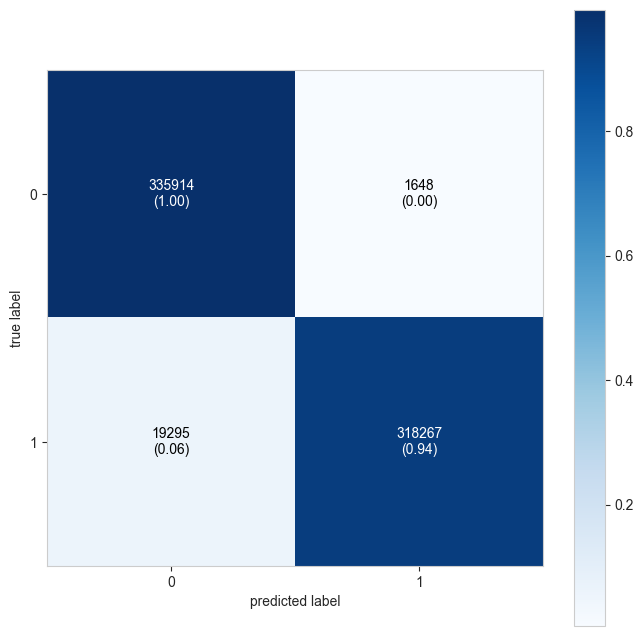

In [ ]:
rf = RandomForestClassifier()
rf_log, rf_cm = cross_validation(rf, X_train, y_train)
plot_confusion_matrix(conf_mat=rf_cm, show_absolute=True, show_normed=True, colorbar=True, figsize=(8, 8));

The fold is: 0
The fold is: 1
The fold is: 2


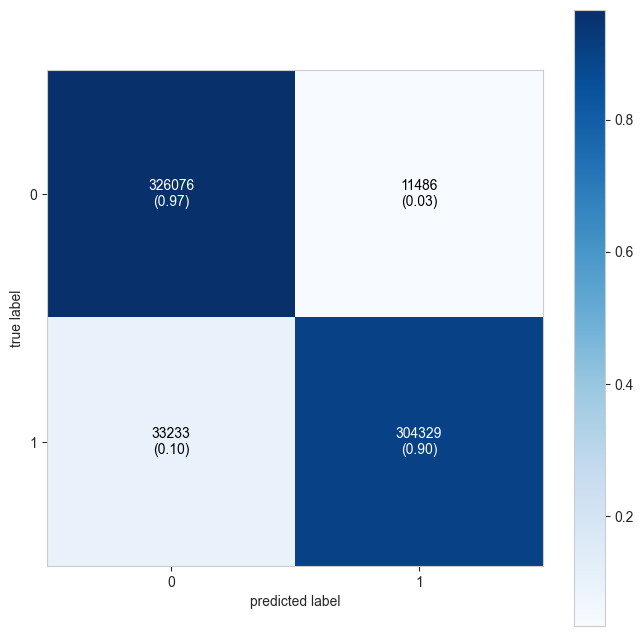

In [ ]:
ada = AdaBoostClassifier()
ada_log, ada_cm = cross_validation(ada, X_train, y_train)
plot_confusion_matrix(conf_mat=ada_cm, show_absolute=True, show_normed=True, colorbar=True, figsize=(8, 8));

The fold is: 0
The fold is: 1
The fold is: 2


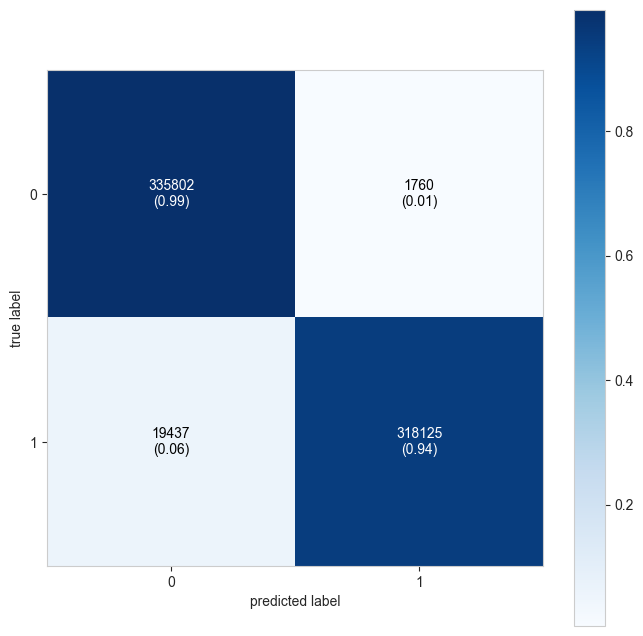

In [ ]:
ext = ExtraTreesClassifier()
ext_log, ext_cm = cross_validation(ext, X_train, y_train)
plot_confusion_matrix(conf_mat=ext_cm, show_absolute=True, show_normed=True, colorbar=True, figsize=(8, 8));

The fold is: 0
The fold is: 1
The fold is: 2


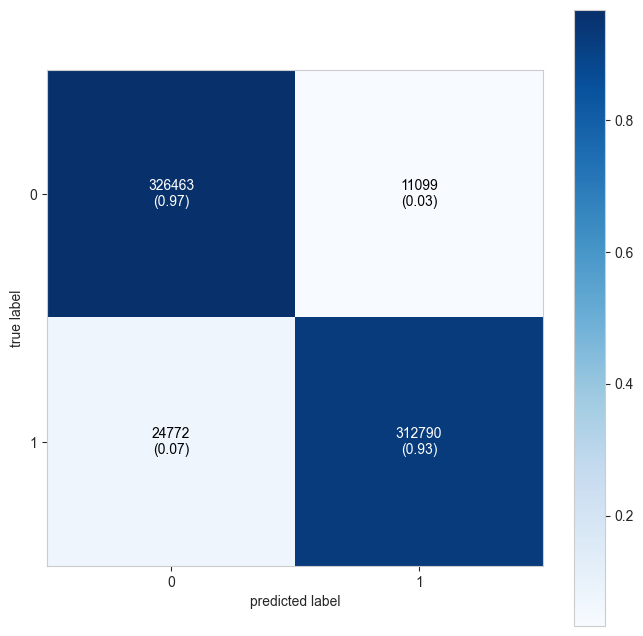

In [ ]:
gb = GradientBoostingClassifier()
gb_log, gb_cm = cross_validation(gb, X_train, y_train)
plot_confusion_matrix(conf_mat=gb_cm, show_absolute=True, show_normed=True, colorbar=True, figsize=(8, 8));

The fold is: 0
The fold is: 1
The fold is: 2


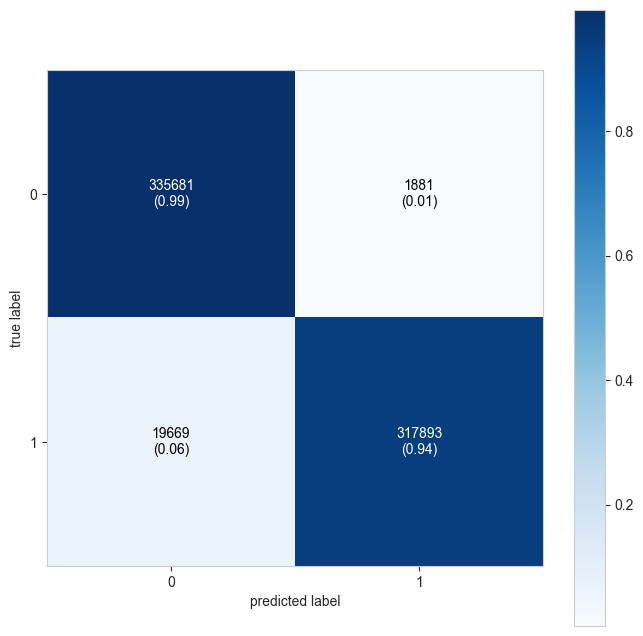

In [ ]:
dt = DecisionTreeClassifier()
dt_log, dt_cm = cross_validation(dt, X_train, y_train)
plot_confusion_matrix(conf_mat=dt_cm, show_absolute=True, show_normed=True, colorbar=True, figsize=(8, 8));

The fold is: 0
The fold is: 1
The fold is: 2


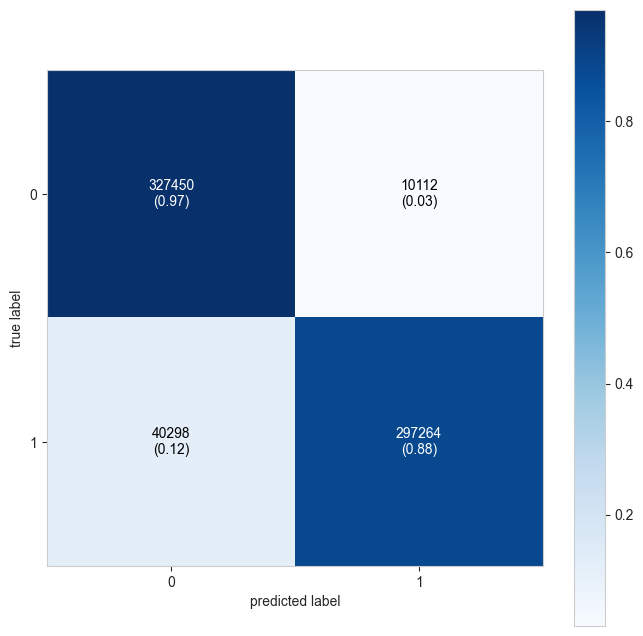

In [ ]:
lr = LogisticRegression()
lr_log, lr_cm = cross_validation(lr, X_train, y_train)
plot_confusion_matrix(conf_mat=lr_cm, show_absolute=True, show_normed=True, colorbar=True, figsize=(8, 8));

The fold is: 0
The fold is: 1
The fold is: 2


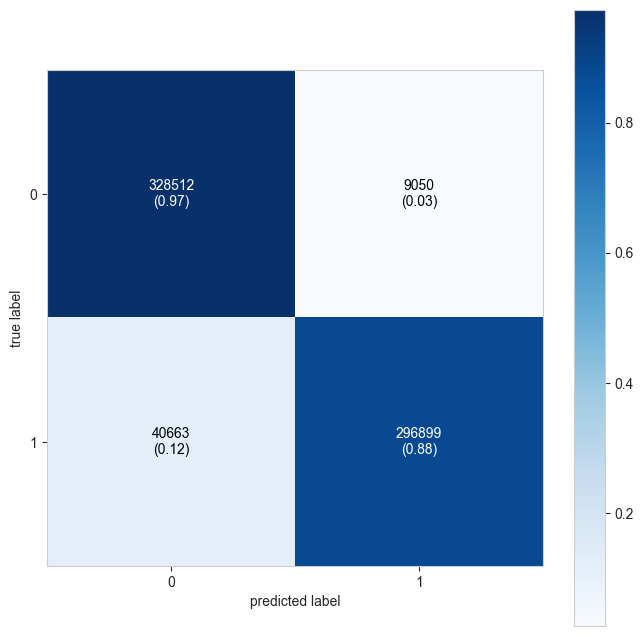

In [ ]:
sgd = SGDClassifier()
sgd_log, sgd_cm = cross_validation(sgd, X_train, y_train)
plot_confusion_matrix(conf_mat=sgd_cm, show_absolute=True, show_normed=True, colorbar=True, figsize=(8, 8));

The fold is: 0
The fold is: 1
The fold is: 2


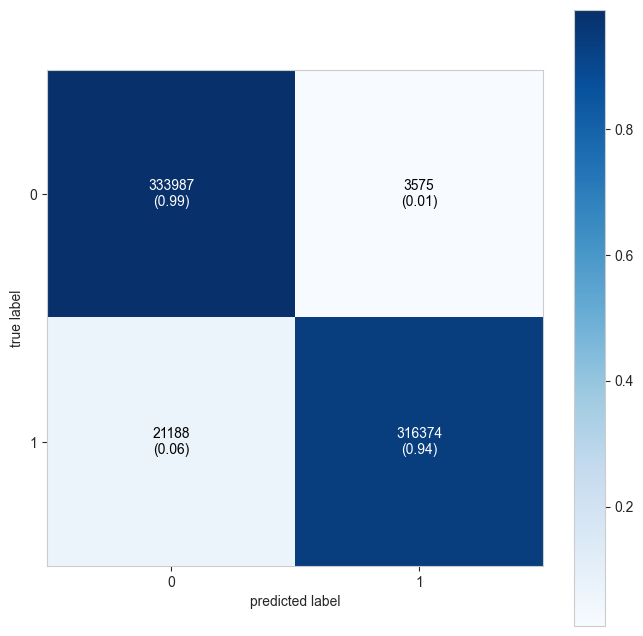

In [ ]:
xgb = XGBClassifier()
xgb_log, xgb_cm = cross_validation(xgb, X_train, y_train)
plot_confusion_matrix(conf_mat=xgb_cm, show_absolute=True, show_normed=True, colorbar=True, figsize=(8, 8));

[LightGBM] [Info] Number of positive: 675124, number of negative: 675124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3874
[LightGBM] [Info] Number of data points in the train set: 1350248, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
The fold is: 0
[LightGBM] [Info] Number of positive: 675124, number of negative: 675124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3887
[LightGBM] [Info] Number of data points in the train set: 1350248, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.

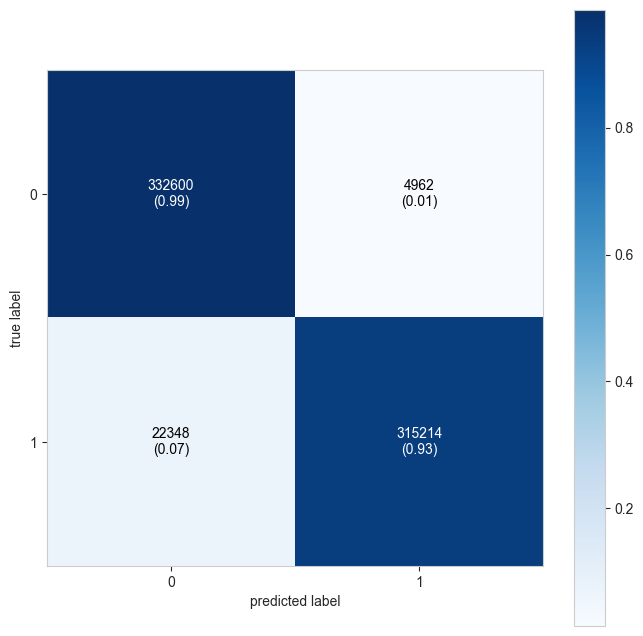

In [ ]:
lgbm = LGBMClassifier()
lgbm_log, lgbm_cm = cross_validation(lgbm, X_train, y_train)
plot_confusion_matrix(conf_mat=lgbm_cm, show_absolute=True, show_normed=True, colorbar=True, figsize=(8, 8));

Learning rate set to 0.223677
0:	learn: 0.3830830	total: 329ms	remaining: 5m 28s
1:	learn: 0.2815811	total: 477ms	remaining: 3m 58s
2:	learn: 0.2395146	total: 627ms	remaining: 3m 28s
3:	learn: 0.2096440	total: 783ms	remaining: 3m 15s
4:	learn: 0.1941639	total: 932ms	remaining: 3m 5s
5:	learn: 0.1801409	total: 1.09s	remaining: 3m 1s
6:	learn: 0.1738031	total: 1.26s	remaining: 2m 58s
7:	learn: 0.1684982	total: 1.44s	remaining: 2m 59s
8:	learn: 0.1647395	total: 1.62s	remaining: 2m 57s
9:	learn: 0.1620791	total: 1.8s	remaining: 2m 58s
10:	learn: 0.1581067	total: 2.04s	remaining: 3m 3s
11:	learn: 0.1559042	total: 2.2s	remaining: 3m 1s
12:	learn: 0.1545981	total: 2.37s	remaining: 2m 59s
13:	learn: 0.1528614	total: 2.51s	remaining: 2m 57s
14:	learn: 0.1515547	total: 2.64s	remaining: 2m 53s
15:	learn: 0.1506216	total: 2.77s	remaining: 2m 50s
16:	learn: 0.1491150	total: 2.9s	remaining: 2m 48s
17:	learn: 0.1480374	total: 3.06s	remaining: 2m 46s
18:	learn: 0.1461751	total: 3.2s	remaining: 2m 45s


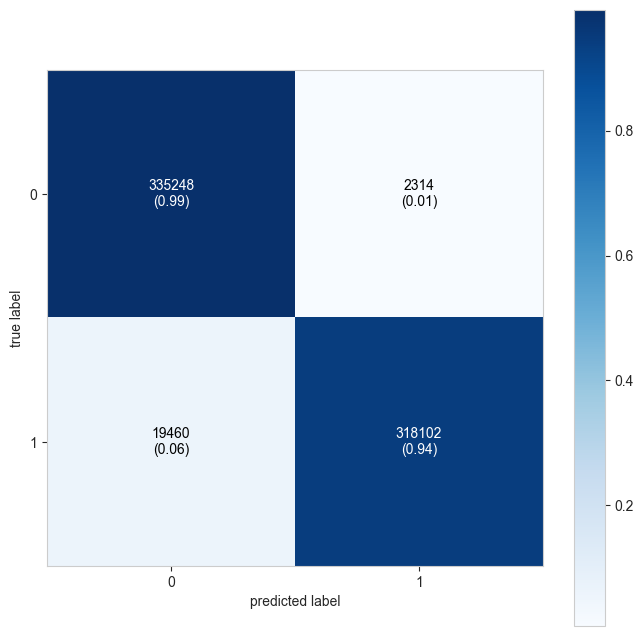

In [ ]:
cat = CatBoostClassifier()
cat_log, cat_cm = cross_validation(cat, X_train, y_train)
plot_confusion_matrix(conf_mat=cat_cm, show_absolute=True, show_normed=True, colorbar=True, figsize=(8, 8));

# Results

In [ ]:
result_df = pd.DataFrame({
    "Model": ["RF", "ADA", "EXT", "GB", "DT", "LR", "SGD", "XGB", "LGBM", "CAT"],
    "Accuracy": [rf_log["Accuracy"].mean(), 
                 ada_log["Accuracy"].mean(), 
                 ext_log["Accuracy"].mean(), 
                 gb_log["Accuracy"].mean(),
                 dt_log["Accuracy"].mean(), 
                 lr_log["Accuracy"].mean(),
                 sgd_log["Accuracy"].mean(),
                 xgb_log["Accuracy"].mean(),
                 lgbm_log["Accuracy"].mean(),
                 cat_log["Accuracy"].mean()],
    "F1": [rf_log["F1"].mean(), 
           ada_log["F1"].mean(), 
           ext_log["F1"].mean(), 
           gb_log["F1"].mean(),
           dt_log["F1"].mean(), 
           lr_log["F1"].mean(),
           sgd_log["F1"].mean(),
           xgb_log["F1"].mean(),
           lgbm_log["F1"].mean(),
           cat_log["F1"].mean()],
    "Precision": [rf_log["Precision"].mean(), 
                  ada_log["Precision"].mean(), 
                  ext_log["Precision"].mean(), 
                  gb_log["Precision"].mean(),
                  dt_log["Precision"].mean(), 
                  lr_log["Precision"].mean(),
                  sgd_log["Precision"].mean(),
                  xgb_log["Precision"].mean(),
                  lgbm_log["Precision"].mean(),
                  cat_log["Precision"].mean()],
    "Recall": [rf_log["Recall"].mean(), 
               ada_log["Recall"].mean(), 
               ext_log["Recall"].mean(), 
               gb_log["Recall"].mean(),
               dt_log["Recall"].mean(), 
               lr_log["Recall"].mean(),
               sgd_log["Recall"].mean(),
               xgb_log["Recall"].mean(),
               lgbm_log["Recall"].mean(),
               cat_log["Recall"].mean()]
})

result_df.head(10)

,Model,Accuracy,F1,Precision,Recall
0,RF,0.97,0.97,0.99,0.94
1,ADA,0.93,0.93,0.96,0.90
2,EXT,0.97,0.97,0.99,0.94
3,GB,0.95,0.95,0.97,0.93
4,DT,0.97,0.97,0.99,0.94
5,LR,0.92,0.92,0.97,0.88
6,SGD,0.93,0.92,0.97,0.88
7,XGB,0.96,0.96,0.99,0.94
8,LGBM,0.96,0.96,0.98,0.93
9,CAT,0.97,0.97,0.99,0.94


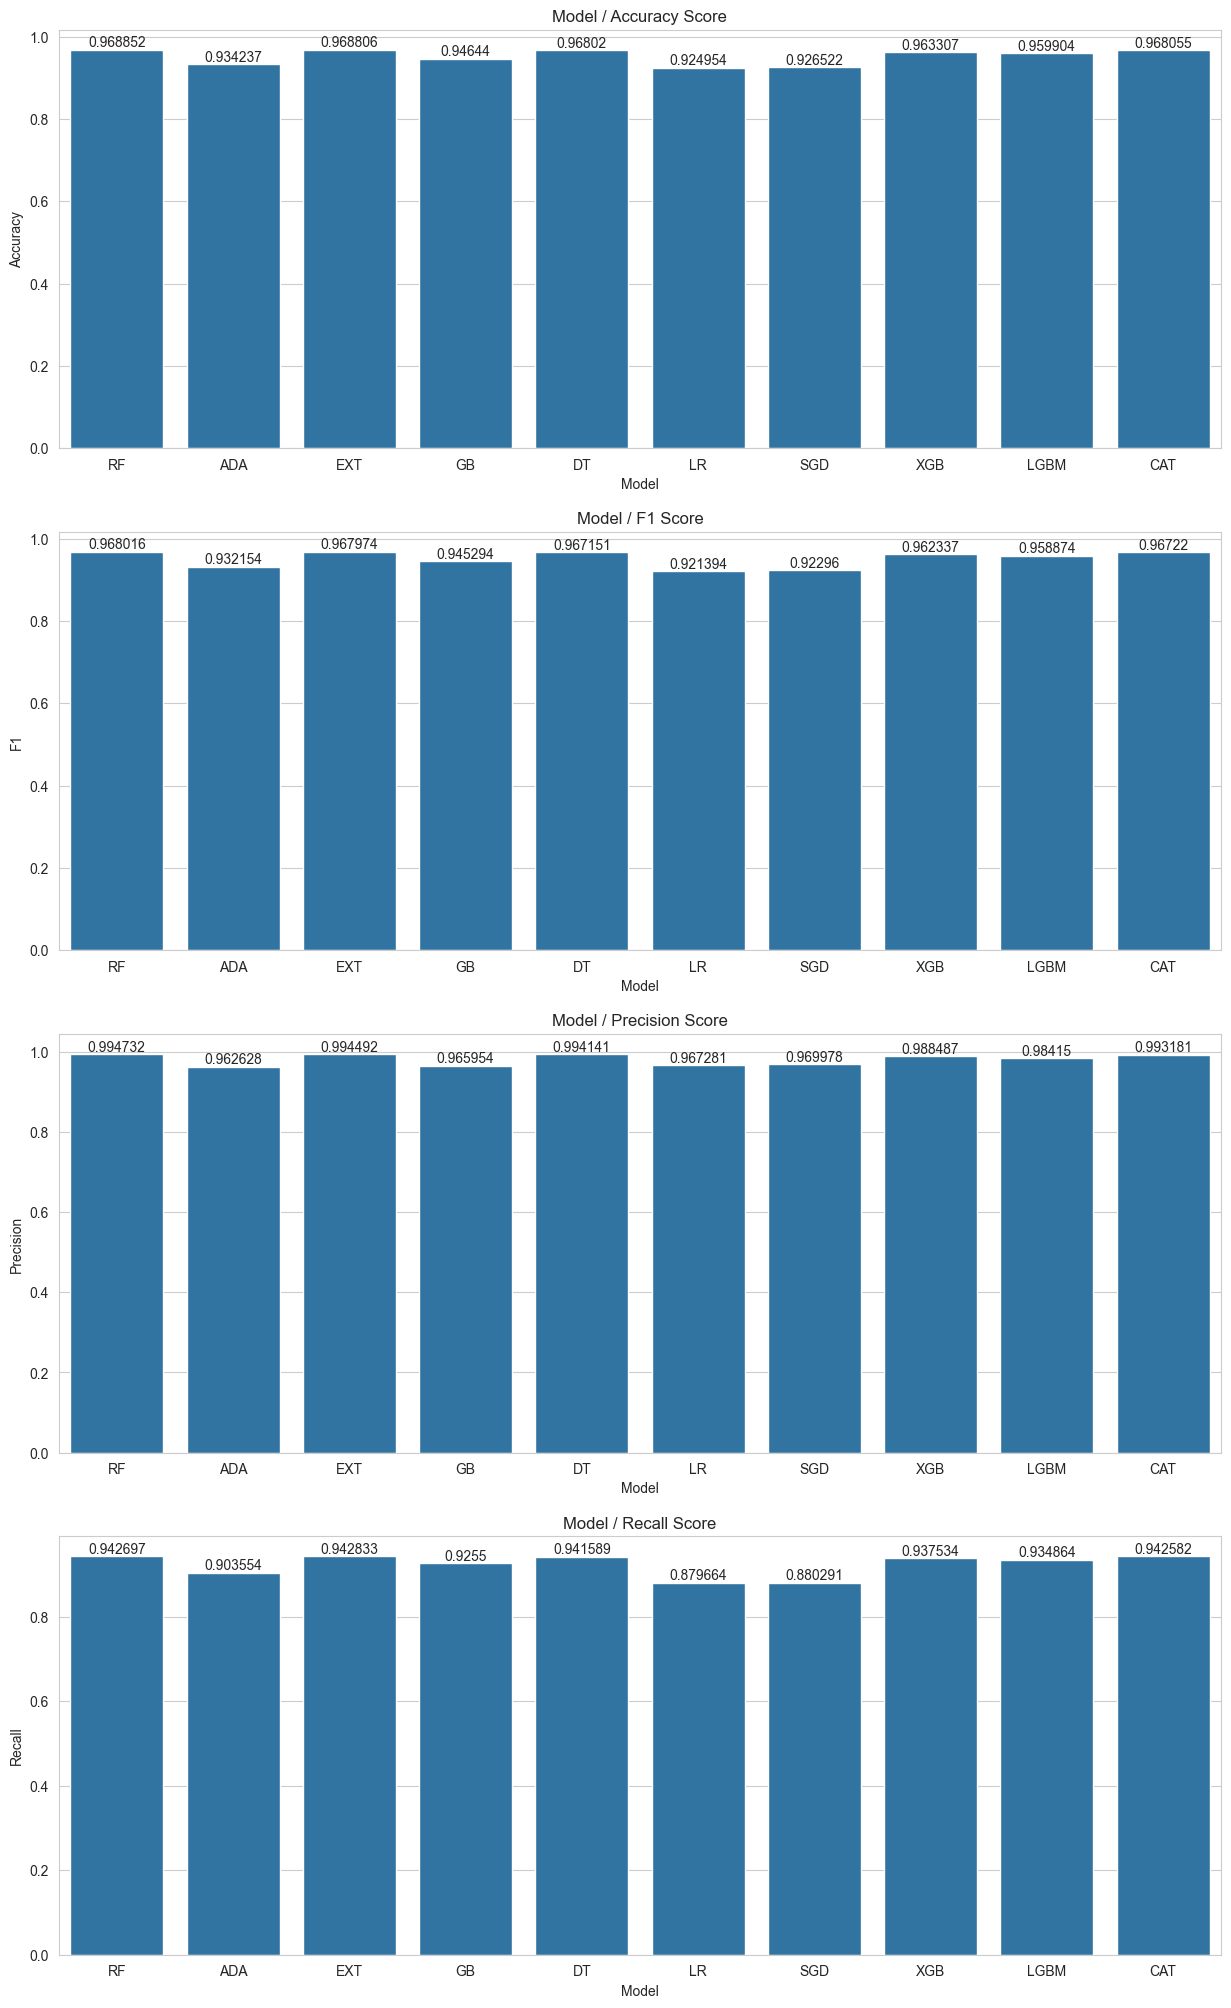

In [ ]:
plt.figure(figsize=(15, 25))

plt.subplot(411)
ax = sns.barplot(data=result_df, x="Model", y="Accuracy")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / Accuracy Score")

plt.subplot(412)
ax = sns.barplot(data=result_df, x="Model", y="F1")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / F1 Score")

plt.subplot(413)
ax = sns.barplot(data=result_df, x="Model", y="Precision")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / Precision Score")

plt.subplot(414)
ax = sns.barplot(data=result_df, x="Model", y="Recall")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / Recall Score")

plt.show()

# create a proxiy server and that will be integrated with the machine learning model and when we send request to our sever our proxiy will going to intercept the http requests and check the request is good in nature or bad

In [9]:
from http.server import HTTPServer, SimpleHTTPRequestHandler
from sklearn.ensemble import RandomForestClassifier
import sys

# Assuming 'ExtractFeatures' and 'predict_model' are defined elsewhere in your code
# from your_model_module import ExtractFeatures, predict_model

class SimpleHTTPProxy(SimpleHTTPRequestHandler):
    proxy_routes = {}
    # Assuming the Random Forest model is already trained and assigned to rf_model
    rf_model = RandomForestClassifier()  # This should be your pre-trained model

    @classmethod
    def set_routes(cls, proxy_routes):
        cls.proxy_routes = proxy_routes

    def do_GET(self):
        parts = self.path.split('/')
        if len(parts) >= 4:
            # Assuming ExtractFeatures returns features in the correct format for the model
            live_data = ExtractFeatures(parts[3])
            prediction = self.rf_model.predict([live_data])  # live_data should be a 2D array
            print(prediction[0])
            if prediction[0] == 1:  # Assuming 1 signifies an intrusion
                print('Intrusion Detected')

        if len(parts) >= 2 and parts[2] in self.proxy_routes:
            url = self.proxy_routes.get(parts[2], '') + '/'.join(parts[2:])
            self.proxy_request(url)
        else:
            super().do_GET()

    # ... existing proxy_request method ...

# ... existing code to start the server ...

# Set up routes and start the HTTP server
SimpleHTTPProxy.set_routes({'proxy_route': 'http://demo.testfire.net'})
with HTTPServer(('127.0.0.1', 9595), SimpleHTTPProxy) as httpd:
    host, port = httpd.socket.getsockname()
    print(f'Listening on http://{host}:{port}')
    try:
        httpd.serve_forever()
    except KeyboardInterrupt:
        print("\nKeyboard interrupt received, exiting.")
        

Listening on http://127.0.0.1:9595


127.0.0.1 - - [06/May/2024 15:46:20] code 501, message Unsupported method ('CONNECT')
127.0.0.1 - - [06/May/2024 15:46:20] "CONNECT tch60157.tch.poe.com:443 HTTP/1.1" 501 -
127.0.0.1 - - [06/May/2024 15:46:20] code 501, message Unsupported method ('CONNECT')
127.0.0.1 - - [06/May/2024 15:46:20] "CONNECT tch475262.tch.poe.com:443 HTTP/1.1" 501 -
127.0.0.1 - - [06/May/2024 15:46:20] code 501, message Unsupported method ('CONNECT')
127.0.0.1 - - [06/May/2024 15:46:20] "CONNECT tch226937.tch.poe.com:443 HTTP/1.1" 501 -
127.0.0.1 - - [06/May/2024 15:46:20] code 501, message Unsupported method ('CONNECT')
127.0.0.1 - - [06/May/2024 15:46:20] "CONNECT tch165639.tch.poe.com:443 HTTP/1.1" 501 -



Keyboard interrupt received, exiting.
